In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, GRU, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
import seaborn as sns
import urllib.request
import zipfile
import os
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt', download_dir='/usr/local/nltk_data')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/local/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## **Reading dataset from a link**

In [3]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2025-05-22 14:30:50--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  41.9MB/s    in 1.9s    

2025-05-22 14:30:52 (41.9 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



## **Unzip the dataset**

In [4]:
!tar xvzf aclImdb_v1.tar.gz

Streaming output truncated to the last 5000 lines.
aclImdb/train/unsup/44983_0.txt
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclImdb/train/unsup/4

## **Reading and Converting the unlabeled dataset to labeled**

In [5]:
import os
def fetch_reviews(path):
  data = []
  #path = 'aclImdb/train/pos/'
  files = [f for f in os.listdir(path)]
  for file in files:
    with open(path+file, "r", encoding='utf8') as f:
      data.append(f.read())

  return data

In [6]:
df_train_pos = pd.DataFrame({'review': fetch_reviews('aclImdb/train/pos/'), 'label': 1})
df_train_neg = pd.DataFrame({'review': fetch_reviews('aclImdb/train/neg/'), 'label': 0})

df_test_pos = pd.DataFrame({'review': fetch_reviews('aclImdb/test/pos/'), 'label': 1})
df_test_neg = pd.DataFrame({'review': fetch_reviews('aclImdb/test/neg/'), 'label': 0})

df = df_train = pd.concat([df_train_pos, df_train_neg, df_test_pos, df_test_neg])

In [7]:
df_train = pd.concat([df_train_pos, df_train_neg])
df_test = pd.concat([df_test_pos, df_test_neg])

## **Loading libraries**

## **Preprocessing and cleaning dataset**

In [8]:
df.sample(20)

,review,label
10723,"""A Tale of Two Sisters"" is a brilliant South K...",1
8609,This was an excellent movie with good acting a...,1
1759,I cannot stop saying how much I loved this mov...,1
8374,This is a very funny movie! I have no idea whe...,1
4032,There are other movies about boarding schools ...,1
4351,I couldn't find anyone to watch DiG! with me b...,1
1592,It seems the makers of this film had trouble d...,0
646,"This isn't art, it's inner-urban, politically-...",0
4489,Now I know why this movie can be bought for so...,0
4790,When a BBC murder thriller is this rife with h...,0


In [9]:
df.describe()

,label
count,50000.000000
mean,0.500000
std,0.500005
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [10]:
df.info

<bound method DataFrame.info of                                                   review  label
0      Visually stunning and full of Eastern Philosop...      1
1      The Master Blackmailer, based off of Sir Arthu...      1
2      Sigh
 I sincerely wonder why all the acclaimed...      1
3      I can understand those who dislike this movie ...      1
4      A lot people get hung up on this films tag as ...      1
...                                                  ...    ...
12495  ... ever! (I always wanted to write that:) Man...      0
12496  Having loved Stephen King's novels and short s...      0
12497  Once upon a time Quentin Tarantino was a relat...      0
12498  You could see the final outcome from a mile aw...      0
12499  First of all, I'd like to say that I really en...      0

[50000 rows x 2 columns]>

In [11]:
df.isna().sum()

,0
review,0
label,0


In [12]:
df['label'].value_counts()

,count
label,
1,25000
0,25000


In [13]:
df.shape

(50000, 2)

## **Visualization to learn more about the dataset**

<ipython-input-14-1f137c49973a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'], palette='Set2')


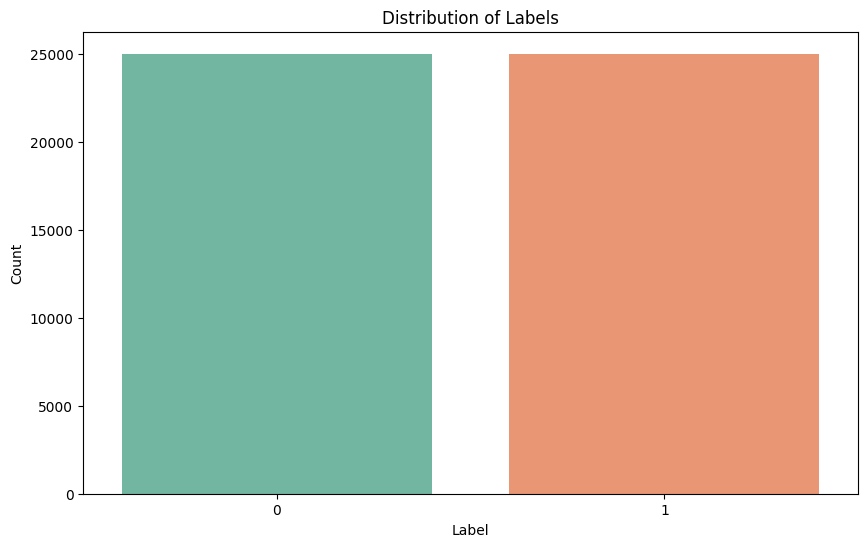

In [14]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df['label'], palette='Set2')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()
#Then data is balanced

In [53]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [54]:
def cleaning_df(text):
    text = re.sub(r'[^a-zA-Z.,?!;]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\.+', '.', text)
    text = re.sub(r'!+', '!', text)
    text = re.sub(r'\?+', '?', text)
    text = re.sub(r'<[^>]+>', ' ', text)
    text = text.lower()
    tokens = word_tokenize(text)
    cleaned = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(cleaned)

In [55]:
sample = "I loved this movies!!, it's so great, wdu think??"
cleaning_df(sample)

'loved movie great wdu think'

In [56]:
df_train['review'] = df_train['review'].apply(cleaning_df)

df_test['review'] = df_test['review'].apply(cleaning_df)

In [57]:
df_train.head()

,review,label
0,visually stunning full eastern philosophy amaz...,1
1,master blackmailer based sir arthur conan doyl...,1
2,sigh sincerely wonder acclaimed supposedly pro...,1
3,understand dislike movie cause lack knowledge ...,1
4,lot people get hung film tag child film certai...,1


In [58]:
df_test.head()

,review,label
0,hope seat heaven comedic throne spike milligan...,1
1,romanian cinema little known romania director ...,1
2,seen movie heard lot praise quite many exclama...,1
3,recently started watch show syndication find b...,1
4,many movie think see movie like count sure see...,1


## **Autocorrect to missing values**

In [59]:
#def autocorrect_df(df_name):
#return df_name.apply(lambda x: ' '.join([spell(word) for word in str(x).split()]))
#df['review'] = autocorrect_df(df['review'])

## **Vectorization**

In [60]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train['review'])

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
with open('/content/drive/MyDrive/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [63]:
train_sequences = tokenizer.texts_to_sequences(df_train['review'])
test_sequences = tokenizer.texts_to_sequences(df_test['review'])

In [64]:
#determine the length of a sentence to find max length for padding using the mean
sentence_lengths = [len(word_tokenize(sentence)) for sentence in df_train['review']]
average_length = np.mean(sentence_lengths)
print(average_length)

125.7108


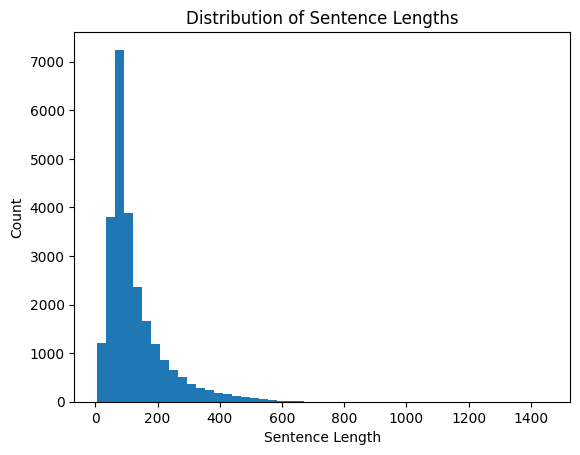

In [65]:
#make sure the mean if correct
import matplotlib.pyplot as plt
plt.hist(sentence_lengths, bins=50)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Count')
plt.show()

In [66]:
#Padding
max_length = 250
X_train = pad_sequences(train_sequences, padding='post', maxlen=max_length)
X_test = pad_sequences(test_sequences, padding='post', maxlen=max_length)

## **Prepare train and test labels**

In [67]:
y_train = df_train['label']
y_test = df_test['label']

In [68]:
X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

In [69]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [70]:
print(f"Training size: {len(X_train)} reviews ({len(X_train)/len(df)*100:.1f}%)")
print(f"Validation size: {len(X_val)} reviews ({len(X_val)/len(df)*100:.1f}%)")
print(f"Test size: {len(X_test)} reviews ({len(X_test)/len(df)*100:.1f}%)")

Training size: 40000 reviews (80.0%)
Validation size: 5000 reviews (10.0%)
Test size: 5000 reviews (10.0%)


## **GloVe embedding**

In [71]:
#Download GloVe
glove_dir = './glove'
if not os.path.exists(glove_dir):
    os.makedirs(glove_dir)

glove_file = os.path.join(glove_dir, 'glove.6B.100d.txt')
if not os.path.exists(glove_file):
    print("Downloading GloVe embeddings...")
    urllib.request.urlretrieve(
        "http://nlp.stanford.edu/data/glove.6B.zip",
        os.path.join(glove_dir, "glove.6B.zip")
    )
    print("Extracting GloVe embeddings...")
    with zipfile.ZipFile(os.path.join(glove_dir, "glove.6B.zip"), 'r') as zip_ref:
        zip_ref.extractall(glove_dir)

In [72]:
#Build GloVe dictionary
print("Loading GloVe embeddings...")
embeddings_index = {}
with open(glove_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print(f"Found {len(embeddings_index)} word vectors.")

Loading GloVe embeddings...
Found 400000 word vectors.


In [73]:
#Bulid the embedding metrices
embedding_dim = 100
word_index = tokenizer.word_index
vocab_size = min(10000, len(word_index) + 1)
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

## **Model Implementation**

In [74]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [94]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(Dropout(0.3))
model.add(GRU(units=64, activation='tanh', return_sequences=True))
model.add(GRU(units=32, activation='tanh'))
model.add(Dropout(0.6))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [95]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=16, callbacks=[early_stopping, reduce_lr])

Epoch 1/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 49s 18ms/step - accuracy: 0.5095 - loss: 0.6922 - val_accuracy: 0.5206 - val_loss: 0.6847 - learning_rate: 0.0010
Epoch 2/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 46s 18ms/step - accuracy: 0.6006 - loss: 0.6400 - val_accuracy: 0.8220 - val_loss: 0.3910 - learning_rate: 0.0010
Epoch 3/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 82s 18ms/step - accuracy: 0.8176 - loss: 0.4134 - val_accuracy: 0.8548 - val_loss: 0.3396 - learning_rate: 0.0010
Epoch 4/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 82s 18ms/step - accuracy: 0.8409 - loss: 0.3686 - val_accuracy: 0.8652 - val_loss: 0.3177 - learning_rate: 0.0010
Epoch 5/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 82s 18ms/step - accuracy: 0.8555 - loss: 0.3406 - val_accuracy: 0.8676 - val_loss: 0.3040 - learning_rate: 0.0010
Epoch 6/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 82s 18ms/step - accuracy: 0.8637 - loss: 0.3248 - val_accuracy: 0.8758 - val_loss: 0.2968 - learning_rate: 0.0010
Epoch 7/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 46s 18ms/step - accura

## **Visualization of accuracy & loss**

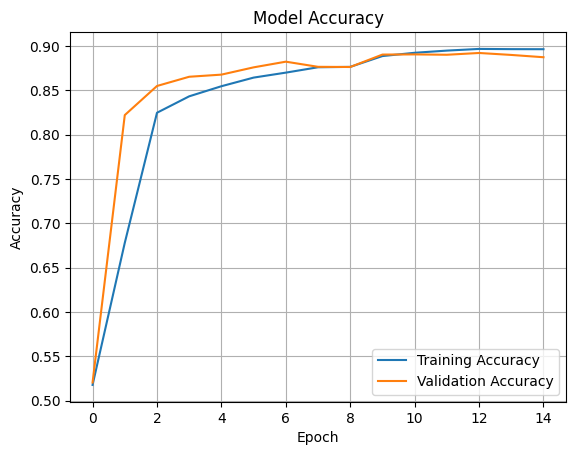

In [96]:
#Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

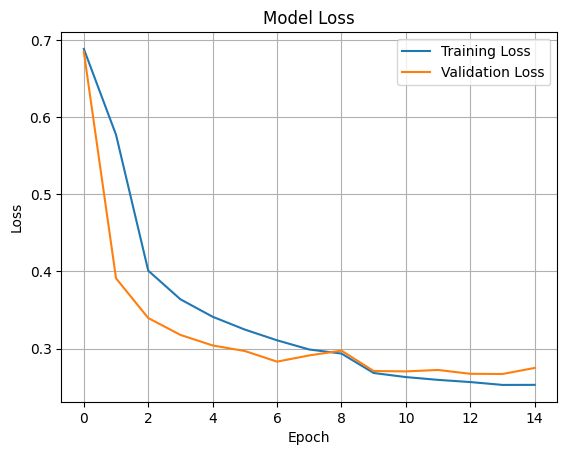

In [97]:
#Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## **Evaluating the model**

In [98]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8800 - loss: 0.2803
Test Loss: 0.274810254573822
Test Accuracy: 0.8870000243186951


In [99]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      2465
           1       0.90      0.88      0.89      2535

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



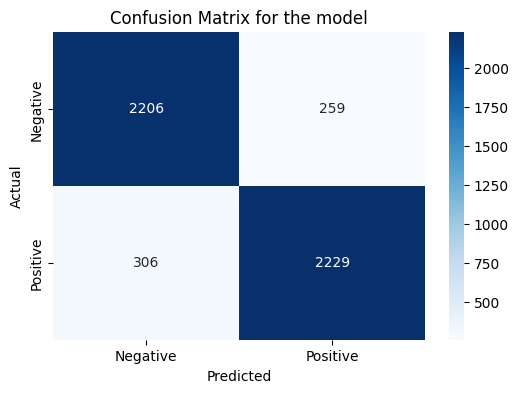

In [100]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for the model")
plt.show()

## **Save the model**

In [101]:
model.save('/content/drive/MyDrive/model.h5')

## **Inference**

In [102]:
VOCAB_SIZE = 10000
MAX_LENGTH = 250

In [103]:
model = load_model('/content/drive/MyDrive/model.h5')

In [105]:
with open('/content/drive/MyDrive/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

In [106]:
lemmatizer = WordNetLemmatizer()

In [110]:
def cleaning_df(text):
    text = re.sub(r'[^a-zA-Z.,?!;]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\.+', '.', text)
    text = re.sub(r'!+', '!', text)
    text = re.sub(r'\?+', '?', text)
    text = re.sub(r'<[^>]+>', ' ', text)
    text = text.lower()
    tokens = word_tokenize(text)
    cleaned = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(cleaned)

In [111]:
def preprocess_text(text):
    text = cleaning_df(text)
    return text

In [112]:
def predict_sentiment(text):
    cleaned_text = preprocess_text(text)
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded = pad_sequences(sequence, padding='post', maxlen=MAX_LENGTH)
    prediction = model.predict(padded, verbose=0)
    sentiment = "positive" if prediction[0][0] > 0.5 else "negative"
    confidence = float(prediction[0][0]) if sentiment == "positive" else 1.0 - float(prediction[0][0])
    return sentiment, confidence

In [115]:
sample_text1 = "Making a brilliant, original horror film is pretty hard these days, since practically everything has already been told, and more than once. Using that premise, director Wes Craven and screenwriter Kevin Williamson came up with Scream, whose cleverness derives from the fact that it knows every single stereotype of the genre and satirizes them."
sample_text2 = " I was looking forward to seeing this movie after watching trailers.. It turned out to be cheap-looking, confusing and boring with teenage cast and a couple of well-known good actors (Ron Livingston and Liev Schreiber) that didn't save it from the bad story and script. The dialogues sound terrible and most are completely not believable. It's a good example of a bad film that is bad starting with the story."

sentiment1, confidence1 = predict_sentiment(sample_text1)
print(f"Text: {sample_text1}")
print(f"Sentiment: {sentiment1}")
print(f"Confidence: {confidence1:.2f}")
print("=========")

sentiment2, confidence2 = predict_sentiment(sample_text2)
print(f"Text: {sample_text2}")
print(f"Sentiment: {sentiment2}")
print(f"Confidence: {confidence2:.2f}")

Text: Making a brilliant, original horror film is pretty hard these days, since practically everything has already been told, and more than once. Using that premise, director Wes Craven and screenwriter Kevin Williamson came up with Scream, whose cleverness derives from the fact that it knows every single stereotype of the genre and satirizes them.
Sentiment: positive
Confidence: 0.80
Text:  I was looking forward to seeing this movie after watching trailers.. It turned out to be cheap-looking, confusing and boring with teenage cast and a couple of well-known good actors (Ron Livingston and Liev Schreiber) that didn't save it from the bad story and script. The dialogues sound terrible and most are completely not believable. It's a good example of a bad film that is bad starting with the story.
Sentiment: negative
Confidence: 1.00
